## Import Libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,f1_score, make_scorer, classification_report, roc_auc_score
from sklearn.dummy import DummyClassifier
import sqlite3
import datetime
import scikitplot as skplt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from gensim.models import Word2Vec

from sklearn.externals.joblib import parallel_backend

import warnings
warnings.filterwarnings('ignore')
global_start = datetime.datetime.now()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Exploratory Data Analysis

### Read The Data

In [2]:
data = pd.read_csv('KickStarter2018_v2.csv')
data.head()

,backers_count,blurb,converted_pledged_amount,created_at,currency,currency_symbol,current_currency,deadline,fx_rate,goal,id,is_starrable,launched_at,name,pledged,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type,loc_country,loc_url,continent,cat_id,cat_name,cat_parent,cat_parent_id,cat_link,creator_id,creator_name,creater_registered,loc_id,loc_name,loc_state,loc_type,profile_id,project_id,project_url
0,4,Handmade glass trees that make a special Chris...,205,2016-06-03,USD,$,USD,2016-06-21,1.000000,1000.0,1145008426,False,2016-06-04,Glass Christmas Trees & Glass Cross,205.0,glass-christmas-trees-and-glass-cross,https://www.kickstarter.com/discover/categorie...,False,False,failed,2016-06-21,1.000000,205.000000,domestic,US,https://www.kickstarter.com/discover/places/tu...,North America,347,Glass,crafts,26,http://www.kickstarter.com/discover/categories...,661261267,Mark & Julie Glocke,False,2508897,Turtle Lake,WI,Town,2543897,2543897,https://www.kickstarter.com/projects/coldglass...
1,171,Perfect pair of Socks for any Adventurer! Sock...,6061,2018-10-24,USD,$,USD,2018-11-15,1.000000,2000.0,1687733153,False,2018-10-30,Socks of Speed and Socks of Elvenkind,6061.0,socks-of-speed-and-socks-of-elvenkind,https://www.kickstarter.com/discover/categorie...,True,False,successful,2018-11-15,1.000000,6061.000000,international,US,https://www.kickstarter.com/discover/places/me...,North America,34,Tabletop Games,games,12,http://www.kickstarter.com/discover/categories...,497057119,Andy,False,2449378,Menasha,WI,Town,3498932,3498932,https://www.kickstarter.com/projects/497057119...
2,9,This is a Series of 6 Books on Blessed Oscar A...,800,2015-06-17,USD,$,USD,2015-08-16,1.000000,4400.0,1608693208,False,2015-07-07,The Complete Homilies of Blessed Oscar Romero:...,800.0,the-complete-homilies-of-blessed-oscar-romero-...,https://www.kickstarter.com/discover/categorie...,False,False,failed,2015-08-16,1.000000,800.000000,domestic,US,https://www.kickstarter.com/discover/places/mi...,North America,327,Translations,publishing,18,http://www.kickstarter.com/discover/categories...,267701790,Convivium Press,False,2450022,Miami,FL,Town,1965582,1965582,https://www.kickstarter.com/projects/convivium...
3,24,Prodeus makes self employment simple and intui...,1484,2017-05-05,USD,$,USD,2017-06-21,1.000000,50000.0,66308869,False,2017-05-22,Prodeus: The Future of Work & Learning,1484.0,prodeus-social-network-learning-community-micr...,https://www.kickstarter.com/discover/categorie...,False,False,failed,2017-06-21,1.000000,1484.000000,domestic,US,https://www.kickstarter.com/discover/places/br...,North America,342,Web,technology,16,http://www.kickstarter.com/discover/categories...,973039847,James Harr,False,12589335,Brooklyn,NY,County,2988723,2988723,https://www.kickstarter.com/projects/973039847...
4,62,"Welcome to Dungeon Corp LTD, a Dungeons and Dr...",1066,2018-12-11,EUR,€,USD,2019-02-15,1.133688,700.0,654590050,False,2019-01-11,Dungeon Corp LTD.: The Adventures of Bob and Tim.,941.0,dungeon-corp-ltd-the-adventures-of-bob-and-tim,https://www.kickstarter.com/discover/categorie...,False,True,live,2019-01-11,1.155864,1087.667629,domestic,ES,https://www.kickstarter.com/discover/places/vi...,Europe,250,Comic Books,comics,3,http://www.kickstarter.com/discover/categories...,496847178,Eternalverse,False,777341,Vigo,Galicia,Town,3533340,3533340,https://www.kickstarter.com/projects/eternalve...


### Number of rows and columns

In [3]:
print('Number of rows : {}'.format(data.shape[0]))
print('Number of columns : {}'.format(data.shape[1]))

Number of rows : 223394
Number of columns : 42


### Column names

In [4]:
data.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'created_at', 'currency', 'currency_symbol', 'current_currency', 'deadline', 'fx_rate', 'goal', 'id', 'is_starrable', 'launched_at', 'name', 'pledged', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'usd_pledged', 'usd_type', 'loc_country', 'loc_url', 'continent', 'cat_id', 'cat_name', 'cat_parent', 'cat_parent_id', 'cat_link', 'creator_id', 'creator_name', 'creater_registered', 'loc_id', 'loc_name', 'loc_state', 'loc_type', 'profile_id', 'project_id', 'project_url'], dtype='object')

### Check for Duplicates

In [5]:
print(data.shape[0] - data.drop_duplicates().shape[0])

0


### Explore The Distribution of 'State'

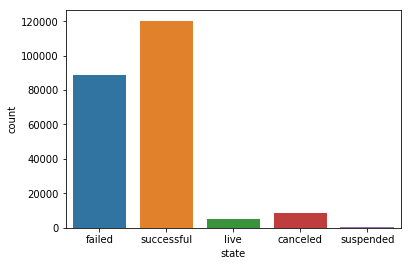

In [6]:
sns.countplot(data['state'])

### Only keeping rows with state as 'successful' or 'failed'

In [7]:
data = data[(data['state']=='failed') | (data['state']=='successful')]
print('Number of rows : {}'.format(data.shape[0]))
print('Number of columns : {}'.format(data.shape[1]))
print('\nDistribution of Class Label:')
print(data['state'].value_counts(normalize=True))

Number of rows : 208994
Number of columns : 42

Distribution of Class Label:
successful    0.57549
failed        0.42451
Name: state, dtype: float64


## Feature Extraction

In [8]:
data = data[['deadline', 'goal',
             'launched_at','staff_pick', 'loc_country', 'cat_name', 'cat_parent', 'blurb','state']]

In [9]:
data['launched_at'] = pd.to_datetime(data['launched_at'])
data['deadline'] = pd.to_datetime(data['deadline'])
data['campaign_length'] = (data['deadline'] - data['launched_at']).dt.days
data['blurb_length'] = data['blurb'].apply(lambda x: len(x.split()))
data = pd.get_dummies(data, columns=['loc_country','cat_name', 'cat_parent'])
data.drop(columns=['launched_at','deadline','blurb'], inplace=True)

In [10]:
y = data['state']
X = data.drop(columns='state')
X = pd.DataFrame(np.array(X.values,dtype=np.float64),columns=X.columns)

## Modelling

### Train-Test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, stratify=y, test_size=0.3)

### Logistic regression + L1 regularization

### Cross-validation 

In [32]:
def cross_val(reg):
    
    start = datetime.datetime.now()
    
    # Create a LR object
    clf = LogisticRegression(class_weight='balanced',penalty=reg, n_jobs=-1)
    
    # Tune hyper parameters using grid search
    param_dict = {}
    param_dict['C'] = [0.001, 0.01, 0.1, 0.5, 1, 10, 100]
    model = GridSearchCV(clf, param_grid=param_dict, scoring='f1_micro', cv=2, n_jobs=-1, verbose=10)
    model.fit(X_train, y_train)
    
    # Plot Hyperparameters v/s AUC score for both train and test data
    params = param_dict['C']
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score']
    
    # ****** Code for plotting **********
    plt.figure(figsize=(12,6))
    plt.plot(params, test_scores, '-o', label='Test Scores')
    plt.plot(params, train_scores, '-o', label='Train Scores')
    plt.xlabel('C values', fontsize=13)
    plt.ylabel('micro_f1 score', fontsize=13)
    plt.title('Hyperparameter v/s Micro_f1 Score', fontsize=16)
    plt.grid('on')
    plt.legend(loc='best', fontsize=12)
    plt.show()
    
    print('\nTime taken for cross-validation : {}'.format(datetime.datetime.now() - start))
    print("\nBest model found using cross-validation : {}".format(model.best_estimator_))
    print('\nMicro_f1 score of the best model using cross-validation : {}'.format(model.best_score_))
    
    weights = model.best_estimator_.fit(X_train, y_train).coef_[0]
    
    
    positive_weights = weights.argsort()[::-1]
    negative_weights = weights.argsort()
    
    cols = X_train.columns
    
    print('\nTop successful class words :',np.take(cols, positive_weights[:10]))
    print('\nTop failed class words :',np.take(cols, negative_weights[:10]))

    if reg == 'l1':
        sparsity = 1 - (np.count_nonzero(weights) / weights.size)
        print('\nsparsity = {}'.format(sparsity))
    
    return model.best_estimator_

### Predictions on Test Data

In [21]:
def make_predictions(clf):
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    y_scores = clf.predict_proba(X_test)
    print('\n########## CLASSIFICATION REPORTS ON TEST DATA ##########')
    print('\n\taccuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
    print('\Micro f1-score on test data : {}'.format(f1_score(y_test, y_pred, average='micro')))
    print('\Micro AUC score on test data : {}'.format(roc_auc_score(y_test, y_scores[:,1], average='micro')))
    print()
    print(classification_report(y_test, y_pred))
    print()
    print()
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    skplt.metrics.plot_roc(y_test, y_scores)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:   11.7s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   12.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   14.5s finished


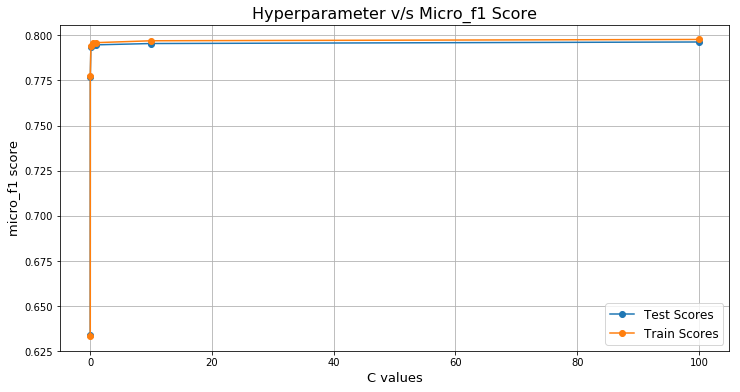


Time taken for cross-validation : 0:00:16.185639

Best model found using cross-validation : LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Micro_f1 score of the best model using cross-validation : 0.7963088280529068

Top successful class words : Index(['cat_name_Video Games', 'cat_name_Product Design', 'cat_name_Comics', 'cat_name_Technology', 'cat_name_Documentary', 'cat_name_Shorts', 'cat_name_Tabletop Games', 'cat_name_Rock', 'cat_name_Indie Rock', 'cat_name_Food'], dtype='object')

Top failed class words : Index(['loc_country_PF', 'loc_country_IR', 'loc_country_LS', 'loc_country_ZW', 'loc_country_WS', 'loc_country_BY', 'loc_country_MT', 'loc_country_BW', 'loc_country_AM', 'loc_country_QA'], dtype='object')

sparsity = 0.04210526315789476


In [33]:
clf =  cross_val('l1')


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.7974927829789948
\Micro f1-score on test data : 0.7974927829789948
\Micro AUC score on test data : 0.8946214101516157

              precision    recall  f1-score   support

      failed       0.70      0.91      0.79     26616
  successful       0.92      0.71      0.80     36083

   micro avg       0.80      0.80      0.80     62699
   macro avg       0.81      0.81      0.80     62699
weighted avg       0.82      0.80      0.80     62699





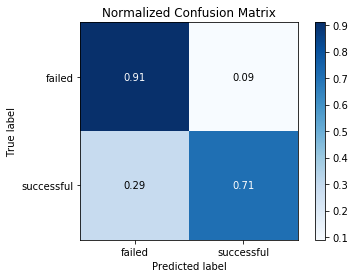

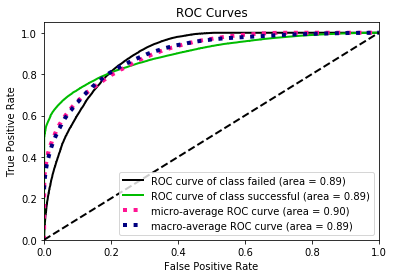

In [34]:
make_predictions(clf)

### SVM + Linear Kernel

### Cross-Validation

In [49]:
def crossval_linear_svm():
    
    start = datetime.datetime.now()
    
    # Create a SVM object
    clf = SGDClassifier(n_jobs=-1, class_weight='balanced', penalty='l1')
    
    # Tune hyper parameters using grid search
    param_dict = {}
    param_dict['alpha'] = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10,20,50]
    model = GridSearchCV(clf, param_grid=param_dict, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=10)
    model.fit(X_train, y_train)
    
    # Plot Hyperparameters v/s AUC score for both train and test data
    params = param_dict['alpha']
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score']
    
    # ****** Code for plotting **********
    plt.figure(figsize=(12,6))
    plt.plot(params, test_scores, '-o', label='Test Scores')
    plt.plot(params, train_scores, '-o', label='Train Scores')
    plt.xlabel('alpha values', fontsize=13)
    plt.ylabel('Weighted F-1 Score', fontsize=13)
    plt.title('Hyperparameter v/s Weighted F-1 Score', fontsize=16)
    plt.grid('on')
    plt.legend(loc='best', fontsize=12)
    plt.show()
    
    print('\nTime taken for cross-validation : {}'.format(datetime.datetime.now() - start))
    print("\nBest model found using cross-validation : {}".format(model.best_estimator_))
    print('\nWeighted F-1 score of the best model using cross-validation : {}'.format(model.best_score_))
    
    weights = model.best_estimator_.fit(X_train, y_train).coef_[0]

    cols = X_train.columns
    positive_weights = weights.argsort()[::-1]
    negative_weights = weights.argsort()
    
    print('\nTop successful class words :',np.take(cols, positive_weights[:10]))
    print('\nTop failed class words :',np.take(cols, negative_weights[:10]))

    return model.best_estimator_

### Predictions of Test Data

In [41]:
def make_predictions(clf):
    calib_clf = CalibratedClassifierCV(clf, cv=2)
    calib_clf.fit(X_train, y_train)
    y_scores = calib_clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    
    print('\n########## CLASSIFICATION REPORTS ON TEST DATA ##########')
    print('\n\taccuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
    print('\tweighted f1-score on test data : {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\tWeighted AUC score on test data : {}'.format(roc_auc_score(y_test, y_scores[:,1], average='weighted')))
    print()
    print(classification_report(y_test, y_pred))
    print()
    print()
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    skplt.metrics.plot_roc(y_test, y_scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


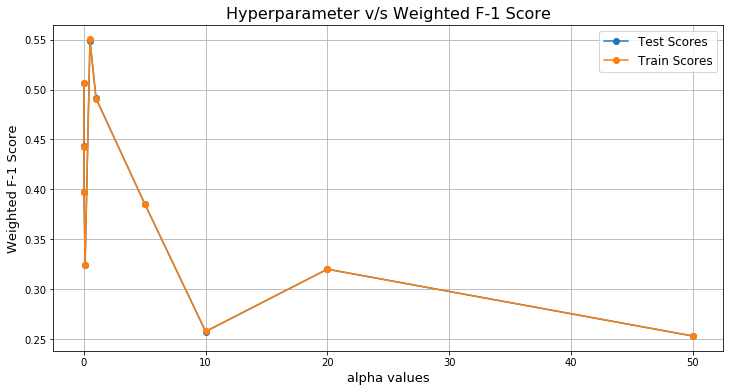


Time taken for cross-validation : 0:01:23.134650

Best model found using cross-validation : SGDClassifier(alpha=0.5, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Weighted F-1 score of the best model using cross-validation : 0.5492051862882016

Top successful class words : Index(['cat_parent_theater', 'loc_country_MX', 'loc_country_MM', 'loc_country_MN', 'loc_country_MO', 'loc_country_MQ', 'loc_country_MR', 'loc_country_MT', 'loc_country_MU', 'loc_country_MV'], dtype='object')

Top failed class words : Index(['campaign_length', 'goal', 'cat_name_Fashion', 'cat_name_Farms', 'cat_name_Farmer's Markets', 'cat_name_Fantasy', 'cat_name_Family', 'cat_name_Faith', '

In [54]:
clf = crossval_linear_svm()


########## CLASSIFICATION REPORTS ON TEST DATA ##########

	accuracy on test data : 0.42450437806025615
	weighted f1-score on test data : 0.2530058450753351
	Weighted AUC score on test data : 0.5

              precision    recall  f1-score   support

      failed       0.42      1.00      0.60     26616
  successful       0.00      0.00      0.00     36083

   micro avg       0.42      0.42      0.42     62699
   macro avg       0.21      0.50      0.30     62699
weighted avg       0.18      0.42      0.25     62699





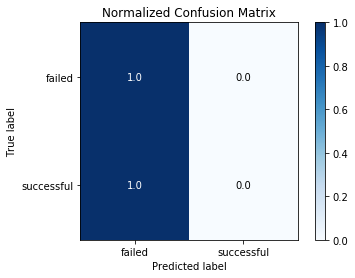

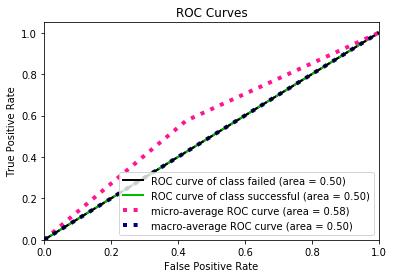

In [55]:
make_predictions(clf)